In [1]:
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import myutils
import ssd_utils
import importlib
import gluoncv as gcv

In [5]:
param_root_path = r'D:\Documents\Data_Files\Parameters'
resnet_50v2 = mx.gluon.model_zoo.vision.resnet50_v2(pretrained=True, root=param_root_path)

In [2]:
ctx = mx.cpu()
backbone_root_path = r'd:/Documents/Data_Files/Parameters//'
ssd = ssd_utils.SSD(backbone_root_path=backbone_root_path, ctx=ctx)
ssd.hybridize()
tensor_pred = ssd(mx.nd.zeros((2, 3, 300, 300), ctx=ctx))
print('tensor_pred shape:', tensor_pred.shape)
print('anchors shape:', ssd.get_anchors().shape)

tensor_pred shape: (2, 1922, 6, 25)
anchors shape: (11532, 4)


In [3]:
root_path = r'D:\Documents\Data_Files\Datasets\Pascal\VOC2012'
dataset = myutils.Dataset(root_path, mode='train')

batch_size = 2
dataloader = mx.gluon.data.DataLoader(dataset.transform((ssd.get_transform_fn())), 
                                      batch_size=batch_size, shuffle=True, last_batch='rollover', 
                                      batchify_fn=myutils.batchify_fn)

aug label 1: [[  7. 501.  94. 814. 518.]]
aug label 2: [[  7.       158.21053   47.554806 257.05264  262.05734 ]]
596
aug label 1: [[  2. 142.  76. 329. 274.]]
aug label 2: [[  2.       71.47651  57.43073 165.60402 207.05289]]
(2, 3, 300, 300)
(2, 1, 5)


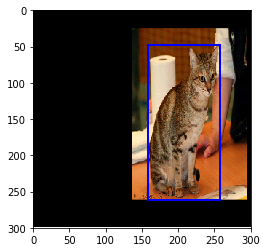

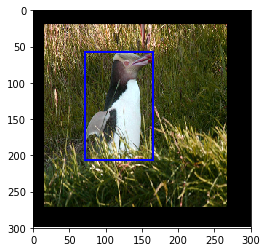

In [168]:
importlib.reload(myutils)
mx_imgs, mx_labels = next(iter(dataloader))
print(mx_imgs.shape)
print(mx_labels.shape)
for i, mx_img in enumerate(mx_imgs):
    plt.imshow(myutils.denormalize(mx_img.transpose((1, 2, 0)).asnumpy()))
    myutils.visualize_boxes(mx_labels[i, :, 1:].asnumpy(), color='blue', fig=plt.gcf(), 
                            is_rltv_cor=True, img_size=[300, 300])
    if not plt.gca().yaxis_inverted():
        plt.gca().invert_yaxis() 
    plt.show()

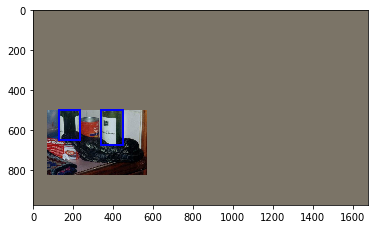


[[  4. 342. 499. 450. 674.]
 [  4. 129. 499. 236. 648.]]
<NDArray 2x5 @cpu(0)>


In [7]:
img, label = dataset[1]
mx_img = mx.nd.array(img)
mx_label = mx.nd.array(label)

aug_img, expand = gcv.data.transforms.image.random_expand(mx_img, fill=[m * 255 for m in myutils.mean])
aug_label = mx_label.copy()
aug_label[:, 1:3] = mx_label[:, 1:3] + mx.nd.array((expand[0], expand[1]))
aug_label[:, 3:5] = mx_label[:, 3:5] + mx.nd.array((expand[0], expand[1]))

aug_label[:, 1:], crop = gcv.data.transforms.experimental.bbox.random_crop_with_constraints(aug_label[:, 1:].asnumpy(), aug_img.shape[:2][::-1])
aug_img = mx.image.fixed_crop(aug_img, *crop)

fig = plt.figure()
plt.imshow(aug_img.asnumpy().astype('int'))
myutils.visualize_boxes(aug_label[:, 1:].asnumpy(), 'blue', fig)
plt.show()

print(aug_label)

In [136]:
aug_img.shape

(420, 326, 3)